延用 stock_data_1301_with_features.csv 的股價資料，完成本次作業要求：
1. 使用Python建立ARIMA模型，預測股票價格，並進行可視化。
2. 使用Python設計一個量化交易策略，並使用歷史資料進行回測。

## 使用Python建立ARIMA模型，預測股票價格，並進行可視化

1301 台灣塑膠工業股份有限公司 為例


In [201]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
# from sklearn.model_selection import train_test_split

# 載入 stock_data_1301_with_features.csv
stock_data = pd.read_csv('stock_data_1301_with_features.csv')
stock_data.tail()

,日期,開盤價,最高價,最低價,收盤價,SMA5,SMA10,SMA20,RSI,MACD,MACD_Signal
654,2024-10-16,48.00,48.45,47.60,47.95,49.09,50.795,50.0075,46.850394,-0.237809,-0.045109
655,2024-10-17,48.00,49.20,47.95,48.40,48.86,50.285,50.0800,49.612403,-0.335980,-0.103284
656,2024-10-18,48.75,49.05,48.10,48.20,48.58,49.805,50.0775,39.090909,-0.425021,-0.167631
657,2024-10-21,48.60,48.65,47.30,47.30,48.04,49.235,50.0300,37.719298,-0.561733,-0.246451
658,2024-10-22,47.50,47.50,46.40,46.70,47.71,48.685,49.9375,10.465116,-0.710306,-0.339222


In [202]:
# 使用Python建立ARIMA模型，預測股票價格，並進行可視化
stock_data['日期'] = pd.to_datetime(stock_data['日期'])
stock_data.set_index('日期', inplace=True)
stock_data = stock_data.asfreq('B')

In [203]:
close_price = stock_data['收盤價']
model = sm.tsa.ARIMA(close_price, order=(5, 1, 0))
results = model.fit()

In [204]:
predict_days = 10
forecast = results.forecast(steps=predict_days) # 預測未來10天的股價

In [205]:
# 列出 預測收盤價 繪製表格 時間、預測收盤價
forecast_df = pd.DataFrame(forecast)
table = go.Figure(
  data=[go.Table(
    header=dict(values=['日期', '預測收盤價']),
    cells=dict(values=[pd.date_range(stock_data.index[-1], periods=predict_days+1, freq='B')[1:], forecast], format=['%Y-%m-%d', '.2f'], align='left')
  )]
)
table.update_layout(title=f' 台股 1301 預測近{predict_days}天收盤價 from {stock_data.index[-1]}', width=600, height=500)
table.show()


In [206]:
# 繪製 收盤價 線圖: 通用函式 用 go.Figure
def plot_closing_price(data, predict_days):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=data['收盤價'], mode='lines', name='歷史收盤價'))
    fig.add_trace(go.Scatter(x=pd.date_range(data.index[-1], periods=10, freq='B'), y=forecast, mode='lines', name='預測收盤價', line=dict(color='orange')))

    fig.update_layout(xaxis_title='日期', yaxis_title='價格',title=f'台股 1301 預測近{predict_days}天收盤價 from {stock_data.index[-1]}', width=1200, height=800)
    fig.show()

plot_closing_price(stock_data,  predict_days)

##  使用Python設計一個量化交易策略，並使用歷史資料進行回測


量化交易策略通常基於技術指標來決定買賣時機。使用簡單移動平均線（SMA）交叉策略。
策略基本原理是：當短期SMA超過長期SMA時買入，反之則賣出。

/var/folders/0l/dmc60s_975jff_p_2_n34cq40000gq/T/ipykernel_20280/1421214345.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



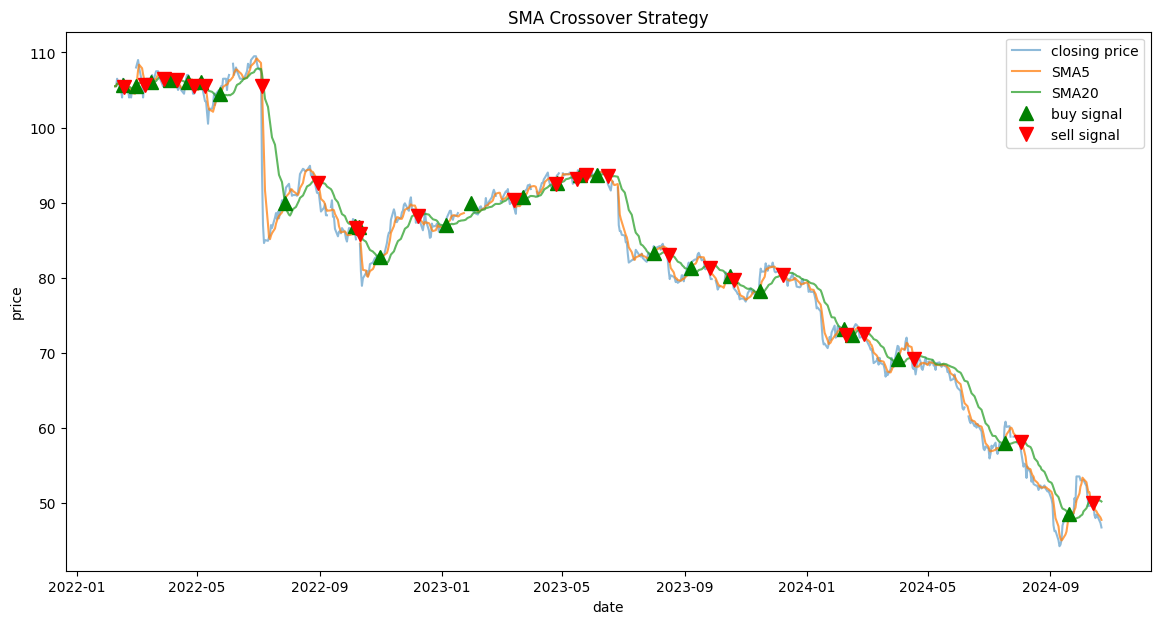

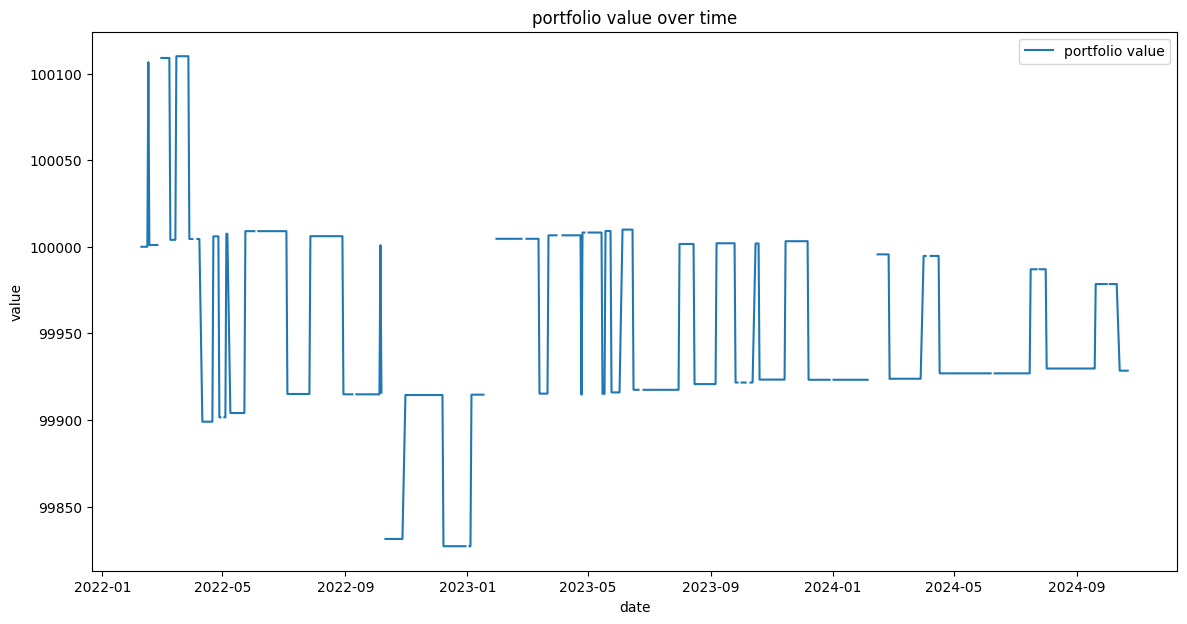

In [207]:
import numpy as np

# 設定短期和長期SMA的窗口
short_window = 5
long_window = 20

# 計算短期和長期SMA
stock_data['SMA_short'] = stock_data['收盤價'].rolling(window=short_window, min_periods=1).mean()
stock_data['SMA_long'] = stock_data['收盤價'].rolling(window=long_window, min_periods=1).mean()

# 產生交易信號
stock_data['Signal'] = 0
stock_data['Signal'][short_window:] = np.where(stock_data['SMA_short'][short_window:] > stock_data['SMA_long'][short_window:], 1, 0)

# 計算持倉
stock_data['Position'] = stock_data['Signal'].diff()

# 回測策略
initial_capital = 100000.0
stock_data['Portfolio Value'] = initial_capital + (stock_data['Position'] * stock_data['收盤價']).cumsum()

# 可視化策略
plt.figure(figsize=(14, 7))
plt.plot(stock_data['收盤價'], label='closing price', alpha=0.5)
plt.plot(stock_data['SMA_short'], label=f'SMA{short_window}', alpha=0.75)
plt.plot(stock_data['SMA_long'], label=f'SMA{long_window}', alpha=0.75)
plt.plot(stock_data.loc[stock_data['Position'] == 1].index, stock_data['SMA_short'][stock_data['Position'] == 1], '^', markersize=10, color='g', lw=0, label='buy signal')
plt.plot(stock_data.loc[stock_data['Position'] == -1].index, stock_data['SMA_short'][stock_data['Position'] == -1], 'v', markersize=10, color='r', lw=0, label='sell signal')
plt.title('SMA Crossover Strategy')
plt.xlabel('date')
plt.ylabel('price')
plt.legend()
plt.show()

# 顯示投資組合價值
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Portfolio Value'], label='portfolio value')
plt.title('portfolio value over time')
plt.xlabel('date')
plt.ylabel('value')
plt.legend()
plt.show()